<a href="https://colab.research.google.com/github/Kriti1400/Implexis-AI/blob/main/bert_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import sklearn
import spacy
import seaborn as sns 
import re
import nltk
import wordcloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (20, 20) 
plt.rcParams['axes.grid']=False
import string
from sklearn.naive_bayes import MultinomialNB

plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

import torch
import time
import datetime

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.5 MB/s 
     |████████████████████████████████| 182 kB 78.6 MB/s 
     |████████████████████████████████| 7.6 MB 71.6 MB/s 


In [ ]:
#import dataset
df = pd.read_csv('liberal_conservative_Reddit.csv')
#df = df.loc[0: 1000]
#keep the first two columns only
df = df.drop(columns = ['Score' , 'Id' , 'Subreddit' , 'URL', 'Num of Comments', 'Text', 'Date Created'])
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 12,854



,Title,Political Lean
5233,Michelle Wu is Boston's first female and first...,Liberal
10592,"How Libertarians in New Hampshire are using ""s...",Conservative
11048,End of the Road: How Money Became Worthless,Conservative
1554,Trump Is Obsessed With Being a Loser,Liberal
11174,Florida Gov. DeSantis Says U.S. In The Olympic...,Conservative
92,Damn that's crazy. What kind of economic model...,Liberal
11588,These Two 'Conservative' Senators Voted for Mo...,Conservative
547,If you're looking for info on the ground in Do...,Liberal
3341,Democrats will be getting a long overdue secon...,Liberal
10021,Buchanan: Are Democrats Kicking Away Their Fut...,Conservative


In [ ]:
#cleaning special characters
# for i in range(len(df['Title'])):
#   df['Title'][i] = df['Title'][i].lower()
#   df['Title'][i] = re.sub(r'\W', ' ', df['Title'][i])
#   df['Title'][i].replace('  ' , ' ')  

# df.head()

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Replace Political Lean values with 0 for Liberal and 1 for Conservative
for i in range(len(df['Political Lean'])):
  df['Political Lean'] = df['Political Lean'].replace(to_replace=['Liberal', 'Conservative'], value=[0, 1])

df.head()

,Title,Political Lean
0,"No matter who someone is, how they look like, ...",0
1,Biden speech draws 38.2 million U.S. TV viewers,0
2,State of the union,0
3,We Should Just Give Poor People Money,0
4,Do it for the Dew,0


In [ ]:
titles = df['Title'].values
labels = df['Political Lean'].values

In [ ]:
# Tokenization

from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original title.
print(' Original: ', titles[0])

# Print the title split into tokens.
print('Tokenized: ', tokenizer.tokenize(titles[0]))

# Print the title mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(titles[0])))

## NOTE: still need to check what is happening with words like "todaaay"

 Original:  No matter who someone is, how they look like, what language they speak, what they wear, remember the human. For the sake of humanity, the working class can and must unite across all arbitrary boundaries.
Tokenized:  ['no', 'matter', 'who', 'someone', 'is', ',', 'how', 'they', 'look', 'like', ',', 'what', 'language', 'they', 'speak', ',', 'what', 'they', 'wear', ',', 'remember', 'the', 'human', '.', 'for', 'the', 'sake', 'of', 'humanity', ',', 'the', 'working', 'class', 'can', 'and', 'must', 'unite', 'across', 'all', 'arbitrary', 'boundaries', '.']
Token IDs:  [2053, 3043, 2040, 2619, 2003, 1010, 2129, 2027, 2298, 2066, 1010, 2054, 2653, 2027, 3713, 1010, 2054, 2027, 4929, 1010, 3342, 1996, 2529, 1012, 2005, 1996, 8739, 1997, 8438, 1010, 1996, 2551, 2465, 2064, 1998, 2442, 15908, 2408, 2035, 15275, 7372, 1012]


In [ ]:
max_len = 0

# For every title...
for sent in titles:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum title length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  105


#### Note
Change the "max_length" to the next power of 2 in accordance with max_len

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = [] 

# For every sentence...
for sent in titles:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens. Attention masks basically pad shorter sentence to match the lenght of the longest sequence
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)     # tokens have been mapped to ids so this is now int
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
title_ids = torch.tensor([i for i in range(len(titles))])

# Print sentence 0, now as a list of IDs.
# input_ids is a (N x L) tensor, N = number of samples (~12k), L = max sentence length (128)
print('Original: ', titles[0])
print('Token IDs:', input_ids[0])
print('Token IDs:', labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  No matter who someone is, how they look like, what language they speak, what they wear, remember the human. For the sake of humanity, the working class can and must unite across all arbitrary boundaries.
Token IDs: tensor([  101,  2053,  3043,  2040,  2619,  2003,  1010,  2129,  2027,  2298,
         2066,  1010,  2054,  2653,  2027,  3713,  1010,  2054,  2027,  4929,
         1010,  3342,  1996,  2529,  1012,  2005,  1996,  8739,  1997,  8438,
         1010,  1996,  2551,  2465,  2064,  1998,  2442, 15908,  2408,  2035,
        15275,  7372,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,  

## Train Data

###Split Data into Training and Test Sets
Could try k-fold validation

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels, title_ids)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
DATA_SIZE = len(dataset)
train_val_size = int(0.9 * DATA_SIZE)
train_size = int(0.9 * train_val_size)
val_size = train_val_size  - train_size 
test_size = DATA_SIZE - train_val_size


# Divide the dataset by randomly selecting samples.
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size], generator=torch.Generator().manual_seed(42))
#change the seed...
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

10,411 training samples
1,157 validation samples
1,286 test samples


###Loading Data into DataLoader
Allows us ot use an iterator instead of for loops

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

###Note
Learning rate might need to be changed depending on the data

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


###Note
Can change num of epochs 

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)           # (B x L) tensor, B = batch size (32), L = max sentence length (128)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)              # Ground truth (B x 1) or (B x 2), verify

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits
        

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = output.loss
            logits = output.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    326.    Elapsed: 0:00:34.
  Batch    80  of    326.    Elapsed: 0:01:08.
  Batch   120  of    326.    Elapsed: 0:01:42.
  Batch   160  of    326.    Elapsed: 0:02:16.
  Batch   200  of    326.    Elapsed: 0:02:50.
  Batch   240  of    326.    Elapsed: 0:03:24.
  Batch   280  of    326.    Elapsed: 0:03:58.
  Batch   320  of    326.    Elapsed: 0:04:32.

  Average training loss: 0.60
  Training epcoh took: 0:04:36

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.52
  Validation took: 0:00:16

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    326.    Elapsed: 0:00:34.
  Batch    80  of    326.    Elapsed: 0:01:08.
  Batch   120  of    326.    Elapsed: 0:01:41.
  Batch   160  of    326.    Elapsed: 0:02:15.
  Batch   200  of    326.    Elapsed: 0:02:49.
  Batch   240  of    326.    Elapsed: 0:03:23.
  Batch   280  of    326.    Elapsed: 0:03:57.
  Batch   320  of    326.    Elapsed: 0:04:30.

  Averag

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.60,0.52,0.74,0:04:36,0:00:16
2,0.47,0.50,0.76,0:04:35,0:00:16


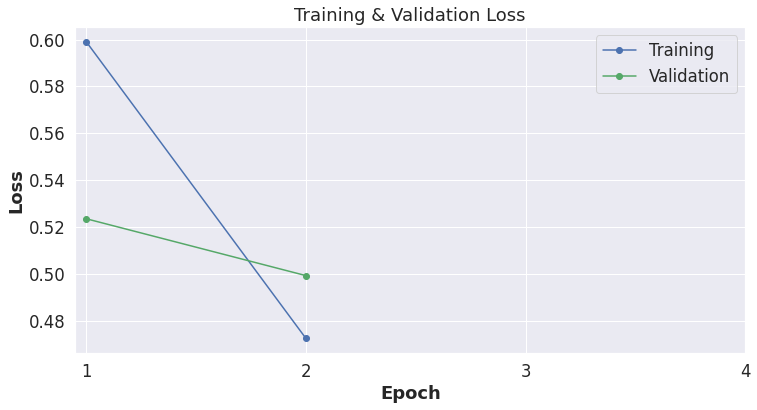

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

df = df.loc[0: 1000]
#keep the first two columns only
df = df.drop(columns = ['Score' , 'Id' , 'Subreddit' , 'URL', 'Num of Comments', 'Text', 'Date Created'])
# Replace Political Lean values with 0 for Liberal and 1 for Conservative
for i in range(len(df['Political Lean'])):
  df['Political Lean'] = df['Political Lean'].replace(to_replace=['Liberal', 'Conservative'], value=[0, 1])
titles = df['Title'].values
labels = df['Political Lean'].values

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
#df = pd.read_csv("liberal_conservative_Reddit.csv")
#df = df.loc[0: 1000]

# # Tokenization
# #from transformers import BertTokenizer
# # Load the BERT tokenizer.
# #print('Loading BERT tokenizer...')
# #tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids = []
# attention_masks = []


# # For every sentence...
# for sent in titles:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
#     encoded_dict = tokenizer.encode_plus(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 128,           # Pad & truncate all sentences.
#                         pad_to_max_length = True,
#                         return_attention_mask = True,   # Construct attn. masks.
#                         return_tensors = 'pt',     # Return pytorch tensors.
#                    )
    
#     # Add the encoded sentence to the list.    
#     input_ids.append(encoded_dict['input_ids'])
    
#     # And its attention mask (simply differentiates padding from non-padding).
#     attention_masks.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
#prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

##Note:
it says we are using the whole dataset for testing which is wrong.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test titles...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, title_id = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  probs = torch.softmax(outputs[0], 1)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  probs = probs.detach().cpu().numpy()

  for i in range(len(title_id)):
      print(titles[title_id[i].item()])
      print(probs[i])
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 12,854 test titles...
Thoughts on these policies for welfare reform?
[0.91962117 0.08037875]
Instagram business accounts be like: become a sociopath
[0.6355776  0.36442238]
AG Merrick Garland plans speech on Jan. 6 investigation for Wednesday
[0.84880877 0.15119122]
Man dumps 80,000 pennies on ex-wife鈥檚 lawn as last child support payment
[0.631449 0.368551]
DSA Stands with Apruebo Dignidad in the Second Round of the Chilean Presidential Elections
[0.96969575 0.03030422]
Truth Social, Trump鈥檚 social network is officially launched
[0.33483842 0.66516155]
Analysis: Biden just dethroned the Welfare Queen
[0.3656041 0.6343959]
DOJ, FBI Will Investigate Companies for 'Illicit Profits'
[0.19678189 0.80321807]
An attorney involved in the West Memphis Three case, in which three teenagers were convicted of killing three boys in 1993, is claiming that evidence related to the case that was believed to be lost or destroyed has been located at the West Memphis Police Department

In [ ]:
titles = df['Title'].values
labels = df['Political Lean'].values
# Replace Political Lean values with 0 for Liberal and 1 for Conservative
for i in range(len(df['Political Lean'])):
  df['Political Lean'] = df['Political Lean'].replace(to_replace=['Liberal', 'Conservative'], value=[0, 1])

print('Positive samples: %d of %d (%.2f%%)' % (df['Political Lean'].values.sum(), len(df['Political Lean'].values), (df['Political Lean'].values.sum() / len(df['Political Lean'].values) * 100.0)))

Positive samples: 4535 of 12854 (35.28%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
#soft max>> scale problem
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


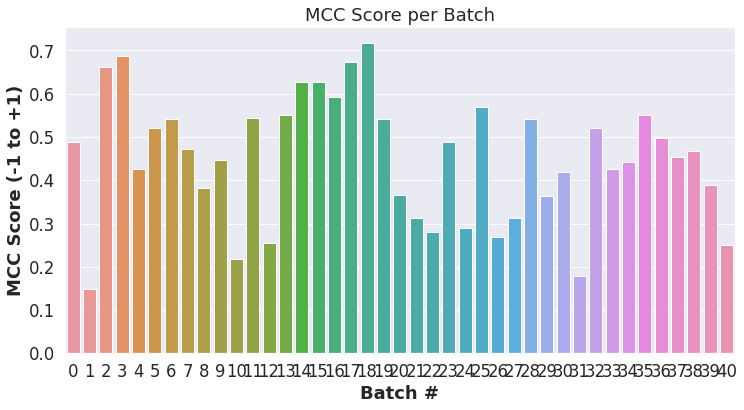

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.453


In [ ]:
from sklearn.metrics import confusion_matrix
res = confusion_matrix(flat_true_labels, flat_predictions)
print("Confusion Matrix")
print(res)

Confusion Matrix
[[689 143]
 [174 280]]
